<a href="https://colab.research.google.com/github/DiwakarBasnet/computer-vision-course/blob/unit-7_Video_and_VideoProcessing/notebooks/Unit%207%20-%20Video%20and%20Video%20Processing/Vivit_Fine_tuned_Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning Video Vision Transformers for Video Classification

## Introduction

Klasifikasi video adalah tugas dalam pembelajaran mesin di mana algoritma dilatih untuk mengenali dan mengategorikan konten video ke dalam kelas atau kategori yang telah ditentukan dengan menganalisis informasi spasial dan temporal yang ada pada frame video. Bidang klasifikasi video telah didominasi oleh model pembelajaran mendalam yang memanfaatkan jaringan saraf konvolusional (CNN) selama ini. Namun, kemunculan model berbasis transformer telah memicu revolusi di berbagai domain, termasuk penglihatan komputer.

Klasifikasi video memiliki berbagai aplikasi, termasuk pengenalan aksi, pengawasan, penyaringan konten, dan sistem rekomendasi. Salah satu algoritma berbasis transformer yang dikembangkan untuk klasifikasi video adalah ViViT, yang juga merupakan salah satu model arsitektur transformer murni pertama yang sukses untuk pemrosesan dan pemahaman video.

Video Vision Transformer (ViViT) adalah versi yang lebih maju dari Vision Transformer (ViT), tetapi untuk video alih-alih hanya gambar. Alasan kita membutuhkan algoritma terpisah untuk video adalah karena ViT, yang untuk gambar, hanya melihat setiap frame secara individu tanpa mempertimbangkan bagaimana mereka saling terkait seiring waktu. Namun, memahami bagaimana frame-frame terhubung dalam video sangat penting untuk benar-benar memahami kontennya, jadi kita membutuhkan algoritma khusus, seperti ViViT, yang dapat menangani aspek temporal tersebut. Model ini telah menetapkan tolok ukur baru untuk akurasi klasifikasi video. Model ini mengungguli metodologi sebelumnya yang didasarkan pada jaringan konvolusional 3D dalam berbagai tolok ukur klasifikasi video.

## Installation

In [1]:
# Install library yang diperlukan
!pip install pytorchvideo evaluate accelerate transformers > /dev/null 2>&1

Kita sekarang akan menguninstall versi terbaru dari torchvision dan menggantinya dengan versi 0.14.1 karena kami akan menggunakan paket dan fungsi di pytorchvideo yang sudah tidak didukung di versi terbaru.

In [2]:
!pip uninstall -y torchvision > /dev/null 2>&1
!pip install torchvision==0.14.1 > /dev/null 2>&1

## Authentication

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Load Dataset

Kami akan menggunakan dataset [UCF101-subset](https://paperswithcode.com/dataset/ucf101) untuk fine-tuning model ViViT kami. Kami hanya menggunakan subset dari dataset asli [UCF101-Action Recognition](https://www.crcv.ucf.edu/data/UCF101.php), ini karena transformer memerlukan GPU yang besar dan bekerja dengan data video besar dapat dengan mudah menghabiskan seluruh memori di Colab. Dataset asli terdiri dari koleksi beragam 101 kategori aksi, mencakup berbagai kegiatan manusia, mulai dari olahraga dan tari hingga aksi sehari-hari. [Subset](https://huggingface.co/datasets/sayakpaul/ucf101-subset) khusus ini dari [sayakpaul](https://huggingface.co/sayakpaul) berisi dataset pelatihan, pengujian, dan validasi, masing-masing dengan 10 kategori pertama dari dataset asli.

In [4]:
from huggingface_hub import hf_hub_download

hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


UCF101_subset.tar.gz:   0%|          | 0.00/171M [00:00<?, ?B/s]

Kode di atas mengunduh subset data kita dari dataset huggingface yang dibuat oleh sayakpaul dalam format tar. Jadi, sekarang kita perlu mengekstrak file tar kita.

In [5]:
!tar xf {file_path}

Setelah ekstraksi file tar, kita bisa melihat struktur direktori dari folder yang baru diekstrak menggunakan kode berikut.

In [6]:
dataset_root_path = "UCF101_subset"

!find {dataset_root_path} | head -4

UCF101_subset
UCF101_subset/train
UCF101_subset/train/ApplyLipstick
UCF101_subset/train/ApplyLipstick/v_ApplyLipstick_g21_c01.avi


In [7]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)
train_count = len(list(dataset_root_path.glob("train/*/*.avi")))
val_count = len(list(dataset_root_path.glob("val/*/*.avi")))
test_count = len(list(dataset_root_path.glob("test/*/*.avi")))
total_video = train_count + val_count + test_count
print(f"Train videos: {train_count}")
print(f"Test videos: {test_count}")
print(f"Validation videos: {val_count}")
print(f"Total videos: {total_video}")

Train videos: 300
Test videos: 75
Validation videos: 30
Total videos: 405


Dalam proses pelatihan, sangat penting untuk memadankan setiap video dengan label kelas yang sesuai. Hal ini memfasilitasi pembelajaran model dengan mengaitkan video dengan kategori tertentu. Untuk mencapai ini, kami mengadopsi pendekatan sistematis sebagai berikut:

* **Mengumpulkan jalur video:** File tar yang baru saja kita ekstrak berisi daftar folder video, kita perlu mengumpulkan jalur file dari video di dalam folder-folder tersebut. Kami memanfaatkan metode `glob` dari modul `pathlib` untuk menemukan file dengan ekstensi ".avi" (*ekstensi video kami*) di dalam direktori tertentu (*train, val, dan test*) di bawah jalur root dataset (*dataset_root_path*).
  
* **Membangun asosiasi label-video:** Kami membangun kamus, *label2id*, yang memetakan setiap label kelas ke ID video yang termasuk dalam kelas tersebut. Ini memungkinkan pencarian cepat ID video yang terkait dengan kelas tertentu. Begitu juga, kami membuat kamus *id2label*, yang menghubungkan setiap ID video dengan label kelas yang sesuai. Hal ini membantu dalam mengambil label kelas berdasarkan ID video.

Korelasi label-ID dilakukan dua kali untuk membangun pemetaan dua arah antara label kelas dan ID integer-nya. Ini memungkinkan pencarian yang efisien antara label kelas dan ID mereka. Memiliki kedua pemetaan ini sangat berguna selama proses pelatihan dan evaluasi model, karena memungkinkan konversi yang mudah antara label kelas dan representasi numeriknya.

In [8]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[PosixPath('UCF101_subset/train/ApplyLipstick/v_ApplyLipstick_g21_c01.avi'),
 PosixPath('UCF101_subset/train/ApplyLipstick/v_ApplyLipstick_g08_c02.avi'),
 PosixPath('UCF101_subset/train/ApplyLipstick/v_ApplyLipstick_g17_c01.avi'),
 PosixPath('UCF101_subset/train/ApplyLipstick/v_ApplyLipstick_g02_c03.avi'),
 PosixPath('UCF101_subset/train/ApplyLipstick/v_ApplyLipstick_g01_c02.avi')]

In [9]:
class_labels = sorted({str(path).split("/")[2] for path in all_video_file_paths})
my_label2id = {label: i for i, label in enumerate(class_labels)}
my_id2label = {i: label for label, i in my_label2id.items()}

print(f"Unique classes: {list(my_label2id.keys())}.")

Unique classes: ['ApplyEyeMakeup', 'ApplyLipstick', 'Archery', 'BabyCrawling', 'BalanceBeam', 'BandMarching', 'BaseballPitch', 'Basketball', 'BasketballDunk', 'BenchPress'].


## Overview of Vision Transformers (ViT)

Sebelum kita melangkah lebih jauh ke dalam Video Vision Transformers (ViViT), mari kita tinjau terlebih dahulu tentang ViT yang menjadi dasar bagi ViViT. ViT mengekstraksi N patch gambar yang tidak tumpang tindih, melakukan proyeksi linier, dan kemudian mengubahnya menjadi token 1D. Urutan token yang dimasukkan ke encoder transformer adalah:

* $Z = [Z_{cls}, Ex_1, Ex_2, ......., Ex_N] + P$

Di mana proyeksi oleh $E$ setara dengan konvolusi 2D. Selain itu, embedding posisi yang dipelajari, $P$, ditambahkan ke token untuk mempertahankan informasi posisi, karena operasi self-attention berikutnya dalam transformer bersifat invariant terhadap permutasi. Token-token ini kemudian diteruskan melalui encoder yang terdiri dari urutan $L$ lapisan transformer. Setiap lapisan ke-$l$ terdiri dari blok Multi-Headed Self-Attention (MSA), Layer Normalization (LN), dan Multi-Layer Perceptron (MLP) sebagai berikut:

* $y^l = MSA(LN(Z^l)) + Z^l$
* $Z^{l+1} = MLP(LN(y^l)) + y^l$

Akhirnya, classifier linier digunakan untuk mengklasifikasikan input yang sudah dienkode.

## Loading ViViT Model

Kami akan melakukan fine-tuning pada model pre-trained `ViViT-b-16x2-kinetics400` untuk klasifikasi video. ViViT adalah pengembangan dari ViT, dan sebagian besar ditujukan untuk di-finetune pada tugas downstream *(yaitu tugas yang mengikuti atau bergantung pada output dari tugas sebelumnya)* seperti klasifikasi video. Di sini, `b` menunjukkan ukuran dasar model, `16` adalah jumlah lapisan yang digunakan oleh model, `2` adalah jumlah kepala perhatian, dan `kinetics400` adalah dataset yang digunakan untuk melatih model tersebut. `Kinetics400` adalah dataset video yang berisi lebih dari 400.000 klip video di seluruh 400 kategori aksi.

In [10]:
model_checkpt = "google/vivit-b-16x2-kinetics400" # pre-trained ViViT model
batch_size = 4

### Loading Video Processor

`VivitImageProcessor` adalah kelas pemrosesan gambar yang digunakan oleh model ViViT, dan merupakan bagian dari arsitektur model tersebut. Kelas ini digunakan untuk memproses data video, yang melibatkan serangkaian langkah pra-pemrosesan untuk mempersiapkan gambar agar dapat dimasukkan ke dalam model transformer. Ini mempersiapkan video untuk model dengan melakukan berbagai tugas pemrosesan gambar seperti pengubahan ukuran, penyesuaian skala, pemotongan, normalisasi, dan sebagainya. Pra-pemrosesan video ini memastikan bahwa model menerima data input dalam format yang konsisten dan optimal, yang sangat penting untuk mencapai prediksi yang akurat dan dapat diandalkan. Ini juga memungkinkan model untuk menangani berbagai ukuran dan format gambar dengan efektif.

In [11]:
from transformers import VivitImageProcessor

image_processor = VivitImageProcessor.from_pretrained(model_checkpt)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

preprocessor_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

Meskipun `VivitImageProcessor` terutama digunakan untuk pra-pemrosesan gambar, checkpoint model diberikan untuk mengonfigurasi langkah-langkah pra-pemrosesan sesuai dengan persyaratan model. Ini memastikan bahwa data input diformat dengan benar untuk model, yang sangat penting untuk mencapai prediksi yang akurat dan dapat diandalkan.

### Transformer models for video

Ada 4 varian model klasifikasi video berbasis transformer murni yang terinspirasi oleh ViT:

1. **Perhatian Spatio-Temporal:**
   * Tokenisasi sampel video menggunakan pendekatan embedding tubelet.
   * Setiap token diproses melalui lapisan patch embedding, ditambahkan encoding posisi, dan kemudian diproses melalui encoder transformer standar.

2. **Encoder Terpisah:**
   * Terdiri dari 2 encoder transformer terpisah: encoder spasial dan encoder temporal.
   * Encoder spasial pertama hanya memodelkan interaksi antara token yang diekstraksi dari indeks temporal yang sama. Representasi level frame digabungkan dan kemudian diteruskan ke encoder temporal.
   * Encoder temporal kedua memodelkan interaksi antara token dari indeks temporal yang berbeda. Token output dari encoder ini akhirnya diklasifikasikan.
   * Untuk transformer spasial, setiap token adalah tubelet yang diekstraksi dari satu klip dan semua token berasal dari temporal yang sama tetapi indeks spasial yang berbeda.
   * Meskipun model ini memiliki lebih banyak lapisan transformer daripada model 1, tetapi memerlukan lebih sedikit operasi floating point (FLOPs).

3. **Self-attention Terpisah:**
   * Model ini sedikit berbeda dari model 1, lapisan MSA dari blok transformer dibagi menjadi 2 bagian. Lapisan MSA pertama menghitung self-attention secara spasial, yaitu antara token yang diekstraksi dari indeks temporal yang sama. Lapisan MSA kedua menghitung self-attention secara temporal, yaitu antara token yang diekstraksi dari indeks spasial yang sama.
   * Urutan self-attention spasial-lalu-temporal atau temporal-lalu-spasial tidak berpengaruh.

4. **Dot-product attention Terpisah:**
   * Model ini mirip dengan model 1 dalam hal arsitektur, satu-satunya perbedaan adalah kepala dalam lapisan MSA pada blok transformer dibagi menjadi 2 bagian. Setengah dari kepala menghitung self-attention dot product antara token yang diekstraksi dari indeks spasial yang sama, sementara kepala lainnya menghitung self-attention dot-product antara token yang diekstraksi dari indeks temporal.

Di antara keempat model tersebut, model 2 adalah yang paling baik kinerjanya. Semua varian model ViViT berusaha menggabungkan token spasial dan temporal secara efektif untuk mengembangkan representasi semantik video yang lebih baik. Model 2 pertama kali memperhatikan aspek spasial dan kemudian aspek temporal dari sampel video. Pendekatan ini disebut perhatian ruang-waktu terpisah.

### Loading model

Ada dua pendekatan dalam mengekstraksi token dari video:

1. **Sampling frame seragam:** Mengambil sampel frame $n_t$ secara merata dari klip video input, menanamkan setiap frame 2D secara independen menggunakan metode yang sama seperti ViT, dan menggabungkan semua token ini. Jika $n_h.n_w$ patch gambar non-tumpang tindih diekstraksi dari setiap frame, maka total $n_t.n_h.n_w$ token akan diteruskan melalui encoder transformer. Metode ini cocok untuk skenario di mana informasi temporal tidak kritis untuk tugas yang sedang ditangani.

2. **Tubelet Embedding:** Metode ini merupakan ekstensi dari embedding ViT ke 3D dan berhubungan dengan konvolusi 3D. Ini adalah metode alternatif di mana "tube" spasio-temporal non-tumpang tindih dari volume input diekstraksi dan diproyeksikan secara linier. Secara intuitif, metode ini menggabungkan informasi spasial-temporal selama tokenisasi, berbeda dengan `Sampling Frame Seragam` di mana informasi temporal dari frame yang berbeda digabungkan oleh transformer. Metode ini sangat berguna untuk tugas-tugas yang memerlukan pemahaman dinamika dan perkembangan dalam video.

Model ViViT menggunakan pendekatan tubelet embedding untuk memproyeksikan frame video ke ruang 3D, mengekstrak patch, dan kemudian meratakan patch ini untuk membuat embedding yang menangkap informasi spasial dan temporal, yang kemudian digunakan untuk membuat embedding dengan menambahkan token CLS dan embedding posisi.

`VivitForVideoClassification` adalah implementasi khusus dari model ViViT yang dirancang untuk tugas klasifikasi video, dibangun di atas arsitektur ViViT. Model ini merupakan bagian dari pustaka `transformers` milik Hugging Face.

In [12]:
from transformers import VivitForVideoClassification

model = VivitForVideoClassification.from_pretrained(
    model_checkpt,
    id2label=my_id2label,
    label2id=my_label2id,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

config.json:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/356M [00:00<?, ?B/s]

Some weights of VivitForVideoClassification were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Preprocessing dataset

Data yang kita unduh masih memerlukan beberapa konstruksi dan serangkaian langkah preprocessing untuk mempersiapkannya sebagai input ke dalam model transformer. Langkah-langkah ini mencakup resizing, normalisasi, cropping, rescaling, dll. yang dilakukan menggunakan pustaka PyTorch video.

In [13]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    RemoveKey,
    Normalize,
    ShortSideScale,
    RandomShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
    Compose,
    Lambda,
)

Saat melakukan fine-tuning, sangat penting untuk memanfaatkan fitur yang telah dipelajari oleh model yang telah dilatih sebelumnya untuk meningkatkan kinerja model yang di-fine-tune. Untuk tujuan itu, perlu untuk memproses data dengan cara yang mirip dengan data yang digunakan selama pre-training. Kita akan menggunakan *image_processor* yang telah dimuat sebelumnya terkait dengan model yang sudah dilatih untuk mendapatkan rata-rata gambar dan deviasi standar yang digunakan untuk menormalkan nilai piksel pada gambar.

Demikian pula, kita akan menggunakan konfigurasi model untuk menemukan jumlah frame yang akan diambil, yang akan digunakan untuk menghitung durasi klip dari data video yang telah diproses.

In [14]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
  height = width = image_processor.size["shortest_edge"]
else:
  height = image_processor.size["height"]
  width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

Kami tidak akan menerapkan transformasi seperti `RandomShortSideScale`, `RandomCrop`, dan `RandomHorizontalFlip` pada data validasi dan uji. Transformasi ini khusus digunakan pada dataset pelatihan untuk menghasilkan data tambahan dalam kategori yang sama, meningkatkan kemampuan model untuk melakukan generalisasi. Kami menggunakan fungsi [`pytorchvideo.data.Ucf101()`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.Ucf101) yang dirancang khusus untuk dataset UCF-101. Fungsi ini mengembalikan objek [`pytorchvideo.data.labeled_video_dataset.LabeledVideoDataset`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.LabeledVideoDataset). Kelas `LabeledVideoDataset` adalah kelas dasar dan menjadi fondasi untuk operasi terkait video dalam dataset PyTorch Video. Jadi, jika Anda ingin menggunakan dataset kustom yang tidak didukung langsung oleh PyTorch Video, Anda dapat memperluas kelas `LabeledVideoDataset` sesuai kebutuhan. Untuk informasi lebih lanjut, lihat dokumentasi API [data](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html). Juga, jika dataset Anda mengikuti struktur yang serupa (seperti yang ditunjukkan di atas), maka menggunakan `pytorchvideo.data.Ucf101()` harus berfungsi dengan baik.

In [15]:
# Training dataset transformations
train_transform = Compose(
  [
    ApplyTransformToKey(
      key="video",
      transform=Compose(
        [
          UniformTemporalSubsample(num_frames_to_sample),
          Lambda(lambda x: x / 255.0),
          Normalize(mean, std),
          RandomShortSideScale(min_size=256, max_size=320),
          RandomCrop(resize_to),
          RandomHorizontalFlip(p=0.5),
        ]
      ),
    ),
  ]
)

# Training dataset
train_dataset = pytorchvideo.data.Ucf101(
  data_path=os.path.join(dataset_root_path, "train"),
  clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
  decode_audio=False,
  transform=train_transform,
)

# Validation and test dataset transformations
val_transform = Compose(
  [
    ApplyTransformToKey(
      key="video",
      transform=Compose(
        [
          UniformTemporalSubsample(num_frames_to_sample),
          Lambda(lambda x: x / 255.0),
          Normalize(mean, std),
          Resize(resize_to),
        ]
      ),
    ),
  ]
)

# Validation and test datasets
val_dataset = pytorchvideo.data.Ucf101(
  data_path=os.path.join(dataset_root_path, "val"),
  clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
  decode_audio=False,
  transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
  data_path=os.path.join(dataset_root_path, "test"),
  clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
  decode_audio=False,
  transform=val_transform,
)

**Note**: The above dataset pipelines are taken from the [official PyTorch Video example](https://pytorchvideo.org/docs/tutorial_classification#dataset).

In [16]:
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(300, 30, 75)

In [17]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [18]:
def investigate_video(sample_video):
  """Utility function to investigate the keys present in a video sample."""
  for k in sample_video:
    if k == "video":
      print(k, sample_video["video"].shape)
    else:
      print(k, sample_video[k])

  print(f"Video label: {my_id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 32, 224, 224])
video_name v_Basketball_g01_c01.avi
video_index 210
clip_index 0
aug_index 0
label 7
Video label: Basketball


### Visualization of preprocessed video

Kami akan memvisualisasikan video yang telah diproses sebelumnya dalam format GIF dan untuk ini, pertama-tama kita perlu membalikkan normalisasi gambar karena gambar yang dinormalisasi memiliki nilai floating antara 0 dan 1 atau -1 dan 1, tetapi kita ingin nilai integer antara 0 dan 255 untuk mewakili gambar yang jelas. Gambar akan dinormalisasi kembali dengan proses kebalikan dari normalisasi, yaitu mengalikan dengan deviasi standar, menambahkan mean, dan kemudian mengalikan dengan 255. Sekarang, kita perlu membuat gif dari tensor video dengan pertama-tama membalikkan normalisasi setiap frame video dan kemudian menyimpannya dalam format gif dengan menambahkan frame-frame tersebut menggunakan paket imageio Python. Tensor video diharapkan memiliki bentuk: (num_frames, num_channels, height, width).

In [19]:
import imageio
import numpy as np
from IPython.display import HTML, Image

def unnormalize_img(img):
  """Un-normalizes the image pixels."""
  img = (img * std) + mean
  img = (img * 255).astype("uint8")
  return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
  """Prepares a GIF from a video tensor."""
  frames = []
  for video_frame in video_tensor:
      frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
      frames.append(frame_unnormalized)
  kargs = {"duration": 0.4}
  imageio.mimsave(filename, frames, "GIF", **kargs)
  return filename

def display_gif(video_tensor, gif_name="sample.gif"):
  """Prepares and displays a GIF from a video tensor."""
  video_tensor = video_tensor.permute(1, 0, 2, 3)    # re-arranging dimension of video_tensor
  gif_filename = create_gif(video_tensor, gif_name)
  return Image(filename=gif_filename)

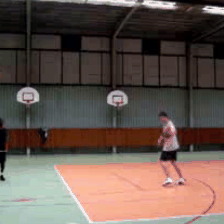

In [20]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

## Train the model

Kami akan memanfaatkan Trainer dari 🤗 Transformers untuk melatih model. Untuk menginstansiasi Trainer, kita perlu mendefinisikan konfigurasi pelatihan dan metrik evaluasi. Kita juga akan menggunakan kelas TrainingArguments, yang berisi semua atribut untuk mengonfigurasi pelatihan. Itu memerlukan nama folder output, yang akan digunakan untuk menyimpan checkpoint dari model.

Sebagian besar argumen pelatihan cukup mudah dipahami, tetapi satu yang cukup penting di sini adalah `remove_unused_columns=False`. Ini akan menghapus fitur yang tidak digunakan oleh fungsi pemanggilan model. Secara default, itu bernilai True karena biasanya ideal untuk menghapus kolom fitur yang tidak digunakan, sehingga mempermudah unpack input ke dalam fungsi pemanggilan model. Namun, dalam kasus kita, kita memerlukan fitur yang tidak terpakai ('***video***' khususnya) untuk membuat `pixel_values` yang diharapkan oleh model kita dalam inputnya.

In [21]:
from transformers import TrainingArguments, Trainer

model_name = model_checkpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ucf101-subset"
num_epochs = 5

args = TrainingArguments(
    new_model_name,
    auto_find_batch_size=True,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
    num_train_epochs=num_epochs,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Selanjutnya, kita akan membutuhkan fungsi untuk mengevaluasi akurasi model kita untuk tujuan pelatihan.

In [22]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  """Computes accuracy on a batch of predictions."""
  predictions = np.argmax(eval_pred.predictions, axis=1)
  return metric.compute(predictions=predictions, references=eval_pred.label_ids)

Kita juga perlu membuat fungsi collate untuk membuat batch data untuk tujuan pelatihan. Setiap batch terdiri dari 2 kunci, nilai piksel dan label.

In [23]:
import torch

def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [24]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

<ipython-input-24-24bc35bb2a98>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [25]:
train_results = trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
0,0.327000,0.041304,0.972973
1,0.002800,0.024778,0.972973


In [26]:
trainer.save_model()
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

***** test metrics *****
  epoch                   =        1.2
  eval_accuracy           =      0.977
  eval_loss               =     0.0847
  eval_runtime            = 0:01:06.01
  eval_samples_per_second =      1.318
  eval_steps_per_second   =      0.333


Sekarang kita dapat mengunggah hasil pelatihan kita ke hub.

In [30]:
trainer.push_to_hub()

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/khaliiishah/vivit-b-16x2-kinetics400-finetuned-ucf101-subset/commit/62efd1c8c54b6467778fe40e6fca8adbc9bf2ee4', commit_message='End of training', commit_description='', oid='62efd1c8c54b6467778fe40e6fca8adbc9bf2ee4', pr_url=None, repo_url=RepoUrl('https://huggingface.co/khaliiishah/vivit-b-16x2-kinetics400-finetuned-ucf101-subset', endpoint='https://huggingface.co', repo_type='model', repo_id='khaliiishah/vivit-b-16x2-kinetics400-finetuned-ucf101-subset'), pr_revision=None, pr_num=None)

## Inference

Sekarang kita akan mencoba melakukan inferensi dengan model yang telah dilatih ulang. Di sini, pertama kita menulis fungsi yang menjalankan inferensi dengan model dan video (video yang telah diproses sebelumnya).

In [33]:
trained_model = VivitForVideoClassification.from_pretrained(new_model_name)

In [34]:
sample_test_video = next(iter(val_dataset))
investigate_video(sample_test_video)

In [35]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [36]:
logits = run_inference(trained_model, sample_test_video["video"])

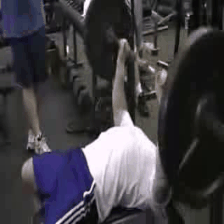

In [37]:
display_gif(sample_test_video["video"])

In [38]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])